In [9]:
import importlib
import os
from datetime import datetime, date

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from data_collection import DataCollection
from multi_input_lsm import MultiInputLSTM as lstm
from data_plotter import DataPlotter
from preprocessing import Preprocessing

import multi_input_lsm
importlib.reload(multi_input_lsm)
from multi_input_lsm import MultiInputLSTM as lstm

import data_plotter
importlib.reload(data_plotter)
from data_plotter import DataPlotter

from algorithmic_trading.experiment_4.src.multi_input_lsm import MultiInputLSTM as lstm
from algorithmic_trading.experiment_4.src.data_plotter import DataPlotter
from algorithmic_trading.experiment_4.src import preprocessing

importlib.reload(preprocessing)
from algorithmic_trading.experiment_4.src.preprocessing import Preprocessing
from algorithmic_trading.experiment_4.src.data_collection import DataCollection
from algorithmic_trading.experiment_4.src.multi_input_lsm import MultiInputLSTM as lstm
from algorithmic_trading.experiment_4.src.data_plotter import DataPlotter
from algorithmic_trading.experiment_4.src import preprocessing

importlib.reload(preprocessing)
from algorithmic_trading.experiment_4.src.preprocessing import Preprocessing

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### DATA PREPARATION #####

In [10]:
# Parameters
predicted_days = 1
tickers = ["GOOGL"]
start_date = "2000-01-01"
end_date = datetime.today().date()
sequence_length = 100 # todo 30, 50, 100, 365
batch_size = 32 # todo 16, 32, 64
data_path = "../data"
os.makedirs(data_path, exist_ok=True)

# Data collection
data_collector = DataCollection(tickers, start_date, end_date, folder_path=data_path)
data_collector.fetch_and_save_all()

# Preprocessing
pp = Preprocessing(folder_path=data_path, split_ratio=0.8, sequence_length=sequence_length)
x_open_train, x_high_train, x_low_train, x_close_train, y_train, y_train_dates,x_open_test, x_high_test, x_low_test, x_close_test, y_test, y_test_dates = pp.preprocess_pipeline()

# Convert data to PyTorch tensors
x_open_train_tensor = torch.tensor(x_open_train, dtype=torch.float32).unsqueeze(-1).to(device)
x_high_train_tensor = torch.tensor(x_high_train, dtype=torch.float32).unsqueeze(-1).to(device)
x_low_train_tensor = torch.tensor(x_low_train, dtype=torch.float32).unsqueeze(-1).to(device)
x_close_train_tensor = torch.tensor(x_close_train, dtype=torch.float32).unsqueeze(-1).to(device)
# x_volume_train_tensor = torch.tensor(x_volume_train, dtype=torch.float32).unsqueeze(-1).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

x_open_test_tensor = torch.tensor(x_open_test, dtype=torch.float32).unsqueeze(-1).to(device)
x_high_test_tensor = torch.tensor(x_high_test, dtype=torch.float32).unsqueeze(-1).to(device)
x_low_test_tensor = torch.tensor(x_low_test, dtype=torch.float32).unsqueeze(-1).to(device)
x_close_test_tensor = torch.tensor(x_close_test, dtype=torch.float32).unsqueeze(-1).to(device)
# x_volume_test_tensor = torch.tensor(x_volume_test, dtype=torch.float32).unsqueeze(-1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader for batching
train_dataset = TensorDataset(
    x_open_train_tensor, x_high_train_tensor, x_low_train_tensor, x_close_train_tensor, y_train_tensor
)
test_dataset = TensorDataset(
    x_open_test_tensor, x_high_test_tensor, x_low_test_tensor, x_close_test_tensor, y_test_tensor
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

[*********************100%***********************]  1 of 1 completed


Data saved to ../data\GOOGL_data.csv


##### MODEL SETUP #####

In [11]:
input_size = 4  # ['Open', 'High', 'Low', 'Close']
hidden_size = 50  # Number of hidden units in LSTM # todo 32, 50, 64, or 128
# output_size = 4  # Predicting 5 values for the next day
# num_layers = 2  # LSTM layers # todo 1 to 3
# dropout = 0.2  # Dropout rate for regularization # todo 0.1 to 0.5
learning_rate = 0.001 # todo 0.001, 0.0005, 0.0001

# Instantiate the model
model = lstm(input_sz=input_size, hidden_sz=hidden_size).to(device) # todo Bidirectional LSTM, Gated Recurrent Unit (GRU)

# Loss and optimizer
criterion = nn.MSELoss() # todo Mean Absolute Error (MAE = L1Loss()), Mean Squared Error (MSE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # todo Adam, AdamW

##### TRAINING THE MODEL #####

In [12]:
num_epochs = 50 # todo 50, 200
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0

    for x_open, x_high, x_low, x_close, y in train_loader:
        optimizer.zero_grad()
        outputs = model(x_open, x_high, x_low, x_close)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.6f}")

Epoch 1/50, Loss: 0.021904
Epoch 2/50, Loss: 0.000191
Epoch 3/50, Loss: 0.000181
Epoch 4/50, Loss: 0.000179
Epoch 5/50, Loss: 0.000152
Epoch 6/50, Loss: 0.000152
Epoch 7/50, Loss: 0.000146
Epoch 8/50, Loss: 0.000158
Epoch 9/50, Loss: 0.000144
Epoch 10/50, Loss: 0.000121
Epoch 11/50, Loss: 0.000109
Epoch 12/50, Loss: 0.000119
Epoch 13/50, Loss: 0.000129
Epoch 14/50, Loss: 0.000111
Epoch 15/50, Loss: 0.000101
Epoch 16/50, Loss: 0.000098
Epoch 17/50, Loss: 0.000109
Epoch 18/50, Loss: 0.000126
Epoch 19/50, Loss: 0.000098
Epoch 20/50, Loss: 0.000086
Epoch 21/50, Loss: 0.000089
Epoch 22/50, Loss: 0.000084
Epoch 23/50, Loss: 0.000117
Epoch 24/50, Loss: 0.000090
Epoch 25/50, Loss: 0.000097
Epoch 26/50, Loss: 0.000076
Epoch 27/50, Loss: 0.000081
Epoch 28/50, Loss: 0.000079
Epoch 29/50, Loss: 0.000077
Epoch 30/50, Loss: 0.000083
Epoch 31/50, Loss: 0.000073
Epoch 32/50, Loss: 0.000070
Epoch 33/50, Loss: 0.000080
Epoch 34/50, Loss: 0.000078
Epoch 35/50, Loss: 0.000072
Epoch 36/50, Loss: 0.000075
E

##### EVALUATING THE MODEL #####

Test Loss: 0.0012
Date: 2021-03-31
Sample prediction (original scale): 101.56, 103.27, 100.41, 101.68
Actual values (original scale): 102.72, 104.31, 102.35, 103.13
--------------------------------------------------
Date: 2021-04-01
Sample prediction (original scale): 102.31, 103.99, 101.17, 102.39
Actual values (original scale): 104.61, 106.79, 104.57, 106.49
--------------------------------------------------
Date: 2021-04-05
Sample prediction (original scale): 104.84, 106.39, 103.66, 104.78
Actual values (original scale): 107.36, 111.45, 107.26, 110.95
--------------------------------------------------
Date: 2021-04-06
Sample prediction (original scale): 108.79, 110.25, 107.60, 108.60
Actual values (original scale): 110.55, 111.40, 110.09, 110.46
--------------------------------------------------
Date: 2021-04-07
Sample prediction (original scale): 109.85, 111.61, 108.92, 109.89
Actual values (original scale): 110.66, 112.22, 110.65, 111.95
-------------------------------------------

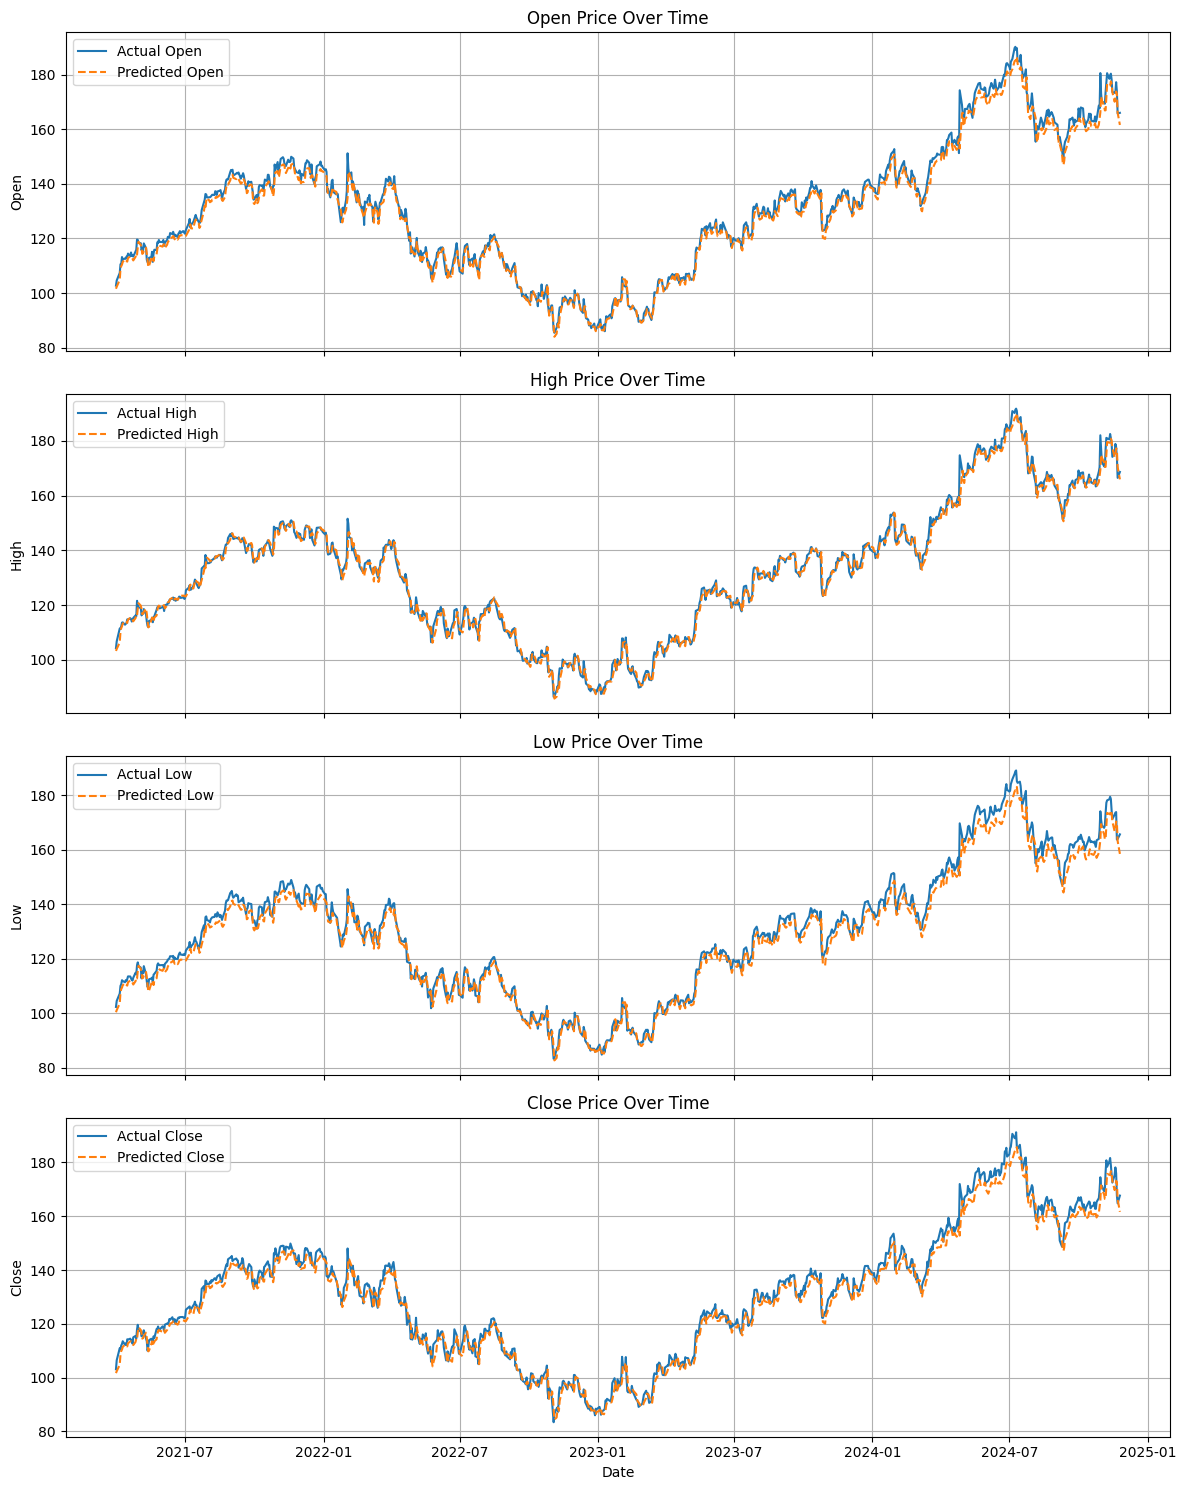

In [13]:
import data_plotter
importlib.reload(data_plotter)
from data_plotter import DataPlotter

model.eval()
test_loss = 0.0
predictions = []
actuals = []

with torch.no_grad():
    for x_open, x_high, x_low, x_close, y in test_loader:
         # Forward pass
        outputs = model(x_open, x_high, x_low, x_close)
        # Compute loss
        loss = criterion(outputs.squeeze(), y)
        test_loss += loss.item()
        # Sotre predictions and actuals
        predictions.append(outputs.cpu())
        actuals.append(y.cpu())

print(f"Test Loss: {test_loss / len(test_loader):.4f}")

# Post-processing predictions and actuals for inverse scaling
predictions = torch.cat(predictions).numpy()
actuals = torch.cat(actuals).numpy()

# Inverse transform OHLC using pp.scaler
predictions_original = pp.scaler.inverse_transform(predictions)
actuals_original = pp.scaler.inverse_transform(actuals)


for i in range(5):
    print(f"Date: {y_test_dates[i]}")
    prediction_str = ", ".join([f"{x:.2f}" for x in predictions_original[i]])
    actual_str = ", ".join([f"{x:.2f}" for x in actuals_original[i]])
    print(f"Sample prediction (original scale): {prediction_str}")
    print(f"Actual values (original scale): {actual_str}")
    print("-" * 50)

# Plotting results
plotter = DataPlotter()
df_results = plotter.create_results_dataframe(y_test_dates, actuals_original, predictions_original)
plotter.plot_results(df_results)

##### Predict ######


Predictions vs Actuals starting from 2023-01-03 for 10 days:
Date: 2023-01-05
Predicted: [88.65654 89.95555 87.75848 88.73548]
Actual: [90.34999847 90.65000153 87.26999664 88.08000183]
Change (%): [-1.87433158 -0.76607873  0.55973374  0.74418644]
---
Date: 2023-01-06
Predicted: [88.383835 89.767624 87.528755 88.51652 ]
Actual: [87.47000122 87.56999969 85.90000153 86.19999695]
Change (%): [1.04473946 2.50956288 1.89610435 2.68737909]
---
Date: 2023-01-09
Predicted: [87.99779  89.39886  87.107025 88.12777 ]
Actual: [86.79000092 87.69000244 84.86000061 87.33999634]
Change (%): [1.39161948 1.94874516 2.64791954 0.90196149]
---
Date: 2023-01-10
Predicted: [87.659065 89.046936 86.708954 87.76671 ]
Actual: [88.36000061 90.05000305 87.86000061 88.01999664]
Change (%): [-0.79327225 -1.11390004 -1.3100919  -0.28776219]
---
Date: 2023-01-11
Predicted: [87.384514 88.76149  86.394844 87.47743 ]
Actual: [85.98000336 88.66999817 85.83000183 88.41999817]
Change (%): [ 1.63353157  0.10318225  0.658094

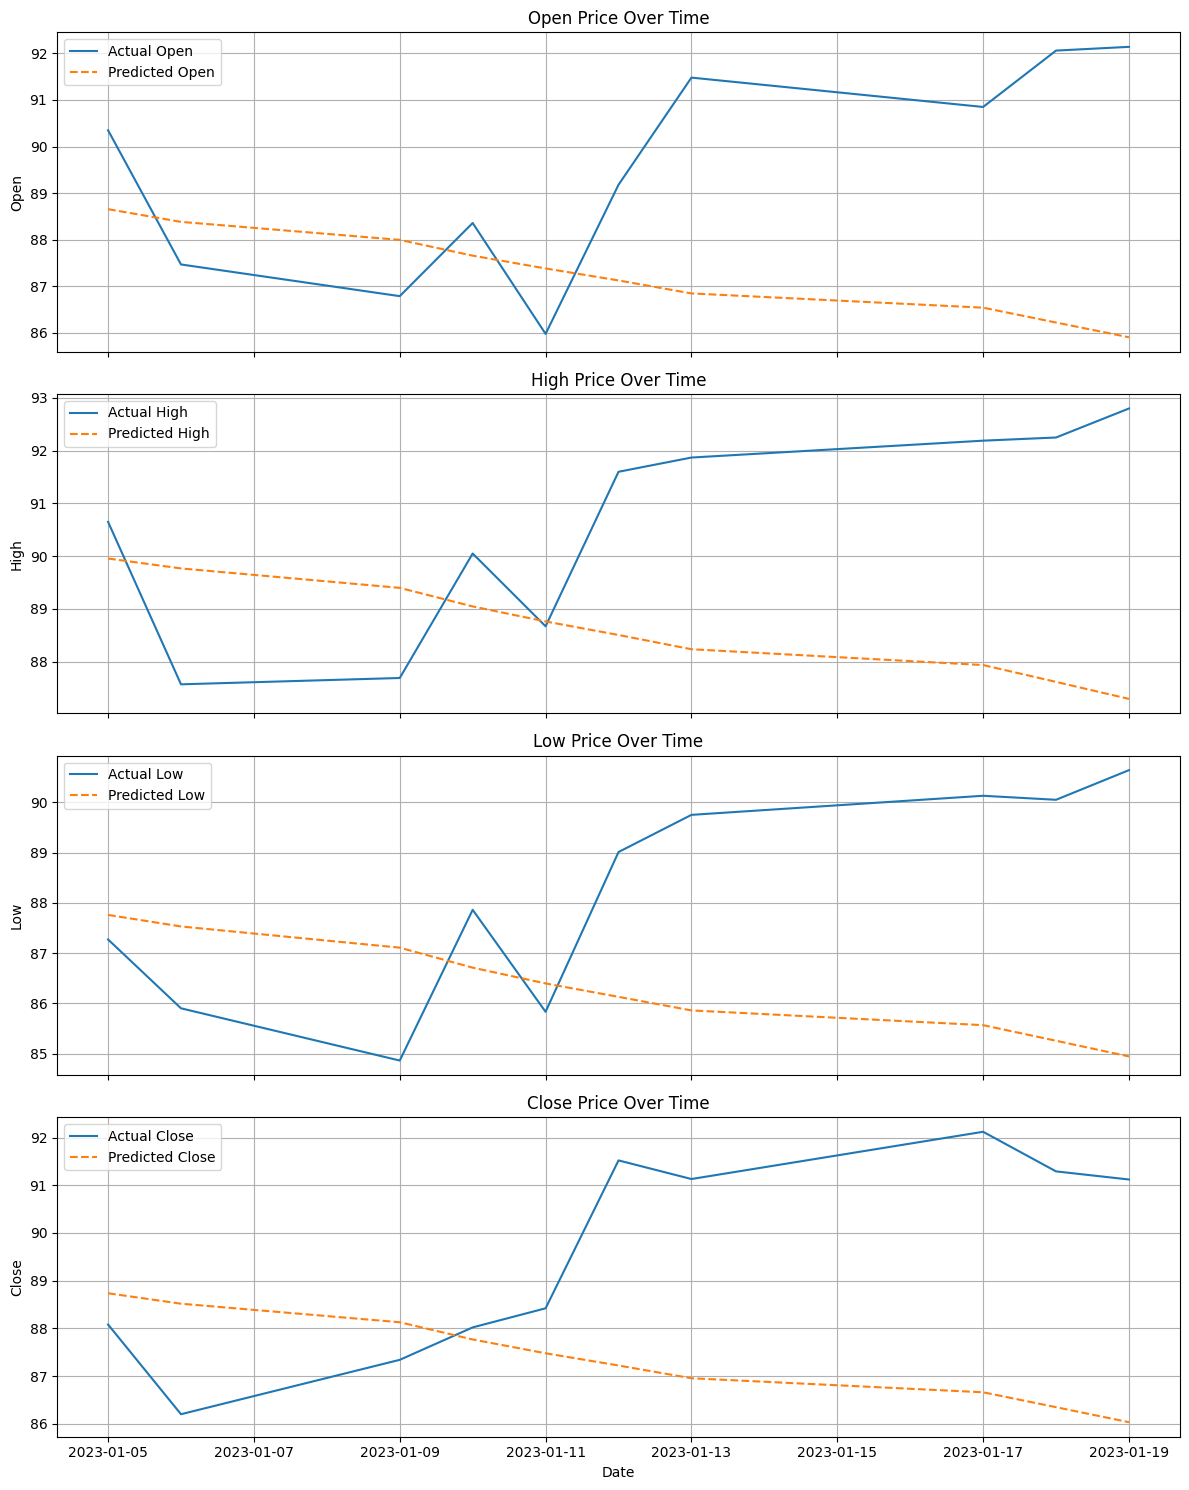

In [14]:
import predictor
importlib.reload(predictor)
from predictor import Predictor

# Initialize the Predictor
predictor = Predictor(
    model=model,
    scaler=pp.scaler,
    # volume_scaler=pp.volume_scaler,
    sequence_length=sequence_length,
    device=device
)

# Specify parameters for prediction
start_date = date(2023, 1, 3)

days_to_predict = 10

# Perform the prediction
dataset = pp.load_data()  # Load the dataset to access dates
dataset['Date'] = pd.to_datetime(dataset['Date']).dt.date
predicted_values, predicted_values_scaled = predictor.predict_future(dataset, start_date, days_to_predict)

# Extract actual values for comparison
start_index = dataset.index[dataset['Date'] == start_date][0] + 1
actual_values = dataset.iloc[start_index:start_index + days_to_predict][['Open', 'High', 'Low', 'Close']].values
actual_values_scaled = pp.scaler.transform(actual_values)

# Evaluate predictions using multiple metrics
mse = np.mean((actual_values_scaled - predicted_values_scaled) ** 2)  # Mean Squared Error
mae = np.mean(np.abs(actual_values_scaled - predicted_values_scaled))  # Mean Absolute Error
variance = np.var(actual_values_scaled - predicted_values_scaled)  # Variance of errors

# Compare predicted values with actual values
print(f"\nPredictions vs Actuals starting from {start_date.strftime('%Y-%m-%d')} for {days_to_predict} days:")

for i, (prediction, actual) in enumerate(zip(predicted_values, actual_values)):
    prediction_date = dataset.iloc[start_index + 1 + i]['Date']
    # Compute changes
    predicted_change = ((prediction - actual_values[i]) / actual_values[i]) * 100
    
    print(f"Date: {prediction_date}")
    print(f"Predicted: {prediction}")
    print(f"Actual: {actual}")
    print(f"Change (%): {predicted_change}")
    print("---")
    
# Print evaluation metrics
print(f"Test Metrics:")
print(f"MSE: {mse:.6f}")  # Mean Squared Error -> Smaller values indicate better model performance.
print(f"MAE: {mae:.6f}")  # Mean Absolute Error -> Provides a more interpretable metric compared to MSE (does not square the errors).
print(f"Variance of errors: {variance:.6f}")  # Variance -> Lower variance indicates that the model consistently makes predictions close to the actual values.

# Plot
plotter = DataPlotter()
# Create a DataFrame for results
df_results = plotter.create_results_dataframe(
    dates=dataset["Date"].iloc[start_index + 1:start_index + 1 + days_to_predict],  # Use the dates for the prediction range
    actuals_original=actual_values,
    predictions_original=predicted_values
)
# Plot results for the prediction range
plotter.plot_results(df_results
)

Simulating the "Without Predictions" Strategy

In [15]:
import random
import simulator
importlib.reload(simulator)
from simulator import InvestmentSimulator

random_index = random.randint(0, len(dataset) - 1)
values = dataset.iloc[random_index:][['Open', 'High', 'Low', 'Close']].values

simulator = InvestmentSimulator(
    prices=values,
    initial_capital=1000,
    profit_threshold=0.10,
    loss_threshold=-0.05,
)

print(f"Simulated buying stock in day: {dataset['Date'][random_index]}")
result = simulator.simulate()
print(result)

Simulated buying stock in day: 2015-02-05
Day 0: Profit/Loss: 0.00%
Day 1: Profit/Loss: 0.76%
Day 2: Profit/Loss: -0.10%
Day 3: Profit/Loss: 1.95%
Day 4: Profit/Loss: 1.54%
Day 5: Profit/Loss: 3.05%
Day 6: Profit/Loss: 4.03%
Day 7: Profit/Loss: 2.87%
Day 8: Profit/Loss: 2.42%
Day 9: Profit/Loss: 3.14%
Day 10: Profit/Loss: 2.26%
Day 11: Profit/Loss: 0.98%
Day 12: Profit/Loss: 1.66%
Day 13: Profit/Loss: 3.30%
Day 14: Profit/Loss: 5.56%
Day 15: Profit/Loss: 6.19%
Day 16: Profit/Loss: 8.53%
Day 17: Profit/Loss: 9.24%
Day 18: Profit/Loss: 9.15%
Day 19: Profit/Loss: 9.74%
Day 20: Profit/Loss: 8.13%
Day 21: Profit/Loss: 8.36%
Day 22: Profit/Loss: 5.67%
Day 23: Profit/Loss: 4.88%
Day 24: Profit/Loss: 5.92%
Day 25: Profit/Loss: 4.37%
Day 26: Profit/Loss: 6.00%
Day 27: Profit/Loss: 5.24%
Day 28: Profit/Loss: 6.86%
Day 29: Profit/Loss: 6.39%
Day 30: Profit/Loss: 6.63%
Day 31: Profit/Loss: 6.71%
Day 32: Profit/Loss: 9.00%
Day 33: Profit/Loss: 7.02%
Day 34: Profit/Loss: 6.38%
Day 35: Profit/Loss: 5

Simulating the "With Predictions" Strategy

In [16]:
import predictor
importlib.reload(predictor)
from predictor import Predictor

# Initialize Predictor
predictor = Predictor(
    model=model,  # Your trained model
    scaler=pp.scaler,
    sequence_length=sequence_length,
    device=device
)

# Random day
start_date = pd.to_datetime(dataset['Date'][random_index]).date()
# Values up to day at random_index
past_values = dataset.iloc[:random_index + 1][['Date', 'Open', 'High', 'Low', 'Close']]

i = 0
result = None

while result is None or result.get('status') not in ['profit', 'loss']:
    i += 1
    predicted_values, predicted_values_scaled = predictor.predict_future(past_values, start_date, i)
    
    simulator = InvestmentSimulator(
        prices=predicted_values,
        initial_capital=1000,
        profit_threshold=0.10,
        loss_threshold=-0.05,
    )
    result = simulator.simulate()
    print("---------")
    
# After the loop, print the final result
print(f"Simulated buying stock in day: {dataset['Date'][random_index]}")
print(f"Simulation completed after {i} days:")
print(result)

Day 0: Profit/Loss: 0.00%
---------
Day 0: Profit/Loss: 0.00%
Day 1: Profit/Loss: -0.75%
---------
Day 0: Profit/Loss: 0.00%
Day 1: Profit/Loss: -0.75%
Day 2: Profit/Loss: -1.54%
---------
Day 0: Profit/Loss: 0.00%
Day 1: Profit/Loss: -0.75%
Day 2: Profit/Loss: -1.54%
Day 3: Profit/Loss: -2.32%
---------
Day 0: Profit/Loss: 0.00%
Day 1: Profit/Loss: -0.75%
Day 2: Profit/Loss: -1.54%
Day 3: Profit/Loss: -2.32%
Day 4: Profit/Loss: -3.09%
---------
Day 0: Profit/Loss: 0.00%
Day 1: Profit/Loss: -0.75%
Day 2: Profit/Loss: -1.54%
Day 3: Profit/Loss: -2.32%
Day 4: Profit/Loss: -3.09%
Day 5: Profit/Loss: -3.86%
---------
Day 0: Profit/Loss: 0.00%
Day 1: Profit/Loss: -0.75%
Day 2: Profit/Loss: -1.54%
Day 3: Profit/Loss: -2.32%
Day 4: Profit/Loss: -3.09%
Day 5: Profit/Loss: -3.86%
Day 6: Profit/Loss: -4.64%
---------
Day 0: Profit/Loss: 0.00%
Day 1: Profit/Loss: -0.75%
Day 2: Profit/Loss: -1.54%
Day 3: Profit/Loss: -2.32%
Day 4: Profit/Loss: -3.09%
Day 5: Profit/Loss: -3.86%
Day 6: Profit/Loss: 